In [ ]:
%load_ext autoreload
%autoreload 2

from PSO import PSO
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from shadow_attacker import ShadowAttack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quick Testing

These work with shadow attack old that is for more general model..

Applying shadow mask


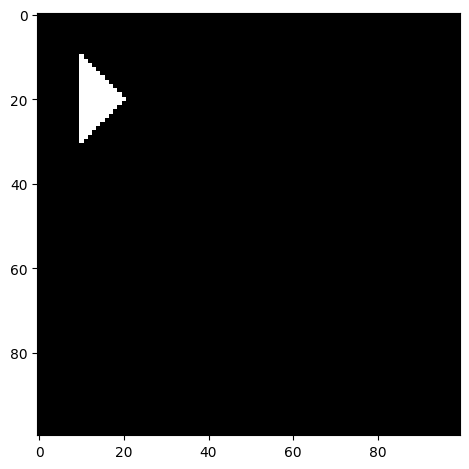

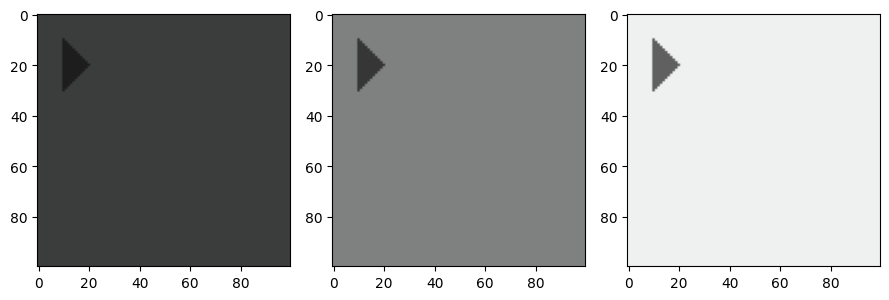

In [91]:
def visualize_binary_masks(mask):
    plt.imshow(mask.cpu().numpy(), cmap="gray")  # Display mask in grayscale
    plt.tight_layout()
    plt.show()


def visualize_perturbed_inputs(X):
    n, c, h, w = X.shape
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for i in range(n):
        ax = axes.flat[i]
        # Transpose from (c, h, w) to (h, w, c) for matplotlib. Removed depth channel
        image = torch.permute(X[i][0:3], (1, 2, 0))
        image = image.cpu().numpy().astype(np.uint8)
        ax.imshow(image, cmap="gray", vmin=0, vmax=255)  # Ensure the values are in uint8 format for display
    plt.tight_layout()
    plt.show()


# Random input
n, c, h, w = 3, 4, 100, 100
X = torch.ones((n, c, h, w), dtype=torch.float16) * 128
X[0] = 60
X[2] = 240

vertices = torch.tensor([[10, 10], [20, 20], [30, 10]], dtype=torch.float)
attacker = ShadowAttack(None)
mask = attacker.get_shadow_mask(vertices, h, w)
visualize_binary_masks(mask)

X_p = attacker.apply_shadow_mask(mask, X)

visualize_perturbed_inputs(X_p)

Testing code for checking inside triangle


In [92]:
def check_points_inside_triangle(vertices, points):
    # Add the third dimension
    n = len(points)
    vertices_3d = torch.cat([vertices, torch.zeros(len(vertices), 1)], dim=1)
    points_3d = torch.cat([points, torch.zeros(n, 1)], dim=1)
    # Check by cross products
    a, b, c = vertices_3d
    cross1 = torch.cross(torch.broadcast_to(b - a, (n, 3)), points_3d - a, dim=1)[:, 2] <= 0
    cross2 = torch.cross(torch.broadcast_to(c - b, (n, 3)), points_3d - b, dim=1)[:, 2] <= 0
    cross3 = torch.cross(torch.broadcast_to(a - c, (n, 3)), points_3d - c, dim=1)[:, 2] <= 0
    return ~(cross1 ^ cross2) & ~(cross2 ^ cross3)


check_points_inside_triangle(
    vertices=torch.tensor([[1, 1], [2, 2], [3, 1]], dtype=torch.float),
    points=torch.tensor([[1.5, 1.5], [1, 1], [2, 0.9]], dtype=torch.float),
)

tensor([ True,  True, False])

Testing PSO


In [ ]:
%load_ext autoreload
%autoreload 2

import torch

# Params
n_particles = 20
dim = 6
c1 = 1.5
c2 = 1.5
w = 0.5
num_iters = 100

pos_lb = torch.zeros(dim)
pos_ub = torch.ones(dim) * 255.0
pos_constraint = torch.stack((pos_lb, pos_ub), dim=0)
speed_lim = 30.0
vel_lb = -torch.ones(dim) * speed_lim
vel_ub = torch.ones(dim) * speed_lim
vel_constraint = torch.stack((vel_lb, vel_ub), dim=0)

# Arbitrary model
model = nn.Sequential(
    nn.Linear(in_features=dim, out_features=1),
    nn.ReLU(),
)


# Define particle's loss function
def cost_fn(particle: torch.Tensor):
    # I won't actually use this value, just for testing that my multiprocessing works with nn modules.
    with torch.no_grad():
        x = model(particle)
    # Returns negative sum of values, so optimal would be (255,255, ...)
    return -torch.sum(particle).item()


# Create PSO
optimizer = PSO(
    num_iters=num_iters,
    n_particles=n_particles,
    dim=dim,
    c1=c1,
    c2=c2,
    w=w,
    pos_constraint=pos_constraint,
    vel_constraint=vel_constraint,
)

best_cost, best_particle = optimizer.optimize(cost_fn=cost_fn)

print(best_cost, best_particle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 2588.65it/s]

tensor(-1530.) tensor([255., 255., 255., 255., 255., 255.])


Testing shadow attacks


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

adv_loss=tensor(46.6834), shadow_polygon=tensor([ 63.6966,  32.3633,   0.0000, 241.8745, 135.9581, 291.8469])


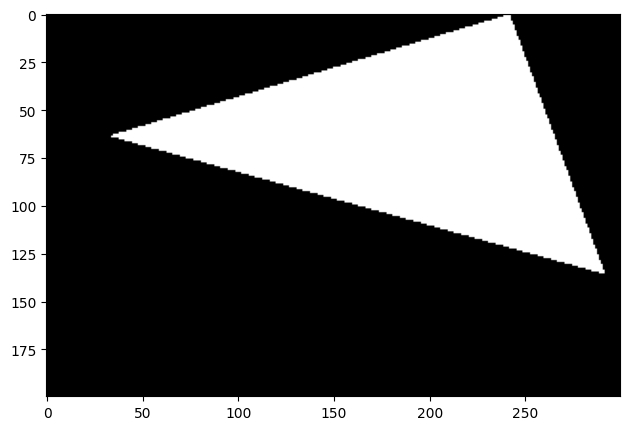

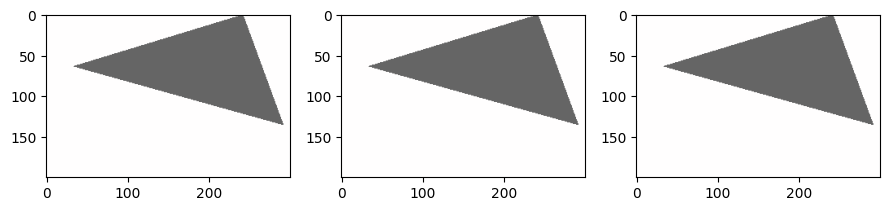

In [ ]:
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        # X of shape (batch_size, seq_length, 3, H, W)
        # Return the first channel of the first image from the sequence.
        return X[:, 0, 0]


model = DummyModel()
X = torch.ones((3, 3, 200, 300), dtype=float) * 255  # seq_length = 3
attacker = ShadowAttack(model=model)
attacker.PSO_params["num_iters"] = 10
attacker.PSO_params["n_particles"] = 20
attacker.PSO_params["c2"] = 3.0
adv_loss, Xp = attacker.generate_attack(X)
visualize_perturbed_inputs(Xp)